In [19]:
import asimov_database as ad
import pandas as pd
import numpy as np

pr = ad.ParquetReader()

# data_events = pr.get_parquet("DOLZ19", "2019-11-13", "events")  # Dicionario
# data_trades = pr.get_parquet("DOLZ19", "2019-11-13", "trades") # Ponteiro
# data_book = pr.get_parquet("DOLZ19", "2019-11-13", "order-book") # Dicionario
# data_level = pr.get_parquet("DOLZ19", "2019-11-13", "level-book") # Dicionario

# data = data_events["incremental"].read().to_pandas()

# trades = data_trades.read().to_pandas()

# bid_price = data_level["bid_price"].read().to_pandas()

# df_data["trade"] = False
# df_data.loc[df_data["msg_seq_num"].isin(df_trades["msg_seq_num"]), "trade"] = True

class Environment:
    def __init__(self, ativo_WDO, ativo_DOL, date, delay, max_order_size, max_position):
        
        self.ativo_WDO = ativo_WDO
        self.ativo_DOL = ativo_DOL

        pr = ad.ParquetReader()

        data_events_WDO = pr.get_parquet(ativo_WDO, date, "events")
        data_events_DOL = pr.get_parquet(ativo_DOL, date, "events")

        self.data_WDO = data_events_WDO["incremental"].read().to_pandas()
        self.data_DOL = data_events_DOL["incremental"].read().to_pandas()

        self.events_concat = pd.concat([self.data_DOL, self.data_WDO], sort=False)
        self.events_concat.sort_values(by=['msg_seq_num'], kind="mergesort", inplace=True)
        open_point = -1 + self.events_concat.reset_index()[self.events_concat.reset_index().status == 'OPEN'].index.values[1]
        closing_time = self.events_concat.reset_index()[self.events_concat.reset_index().status == 'FORBIDDEN'].index.values[-2]
        self.events_concat = self.events_concat[open_point:closing_time]
        self.events_concat = self.events_concat[self.events_concat.side != 'None']

        data_trades = pr.get_parquet(ativo_WDO, date, "trades")
        self.trades = data_trades.read().to_pandas()

        self.data_level_WDO = pr.get_parquet(ativo_WDO, date, "level-book")
        self.data_level_DOL = pr.get_parquet(ativo_DOL, date, "level-book")

        self.bid_inc_code_WDO = self.data_level_WDO["bid_inc_code"].read().to_pandas()[0].values
        self.bid_price_WDO = self.data_level_WDO["bid_price"].read().to_pandas().values
        self.bid_quantity_WDO = self.data_level_WDO["bid_quantity"].read().to_pandas().values
        self.bid_ts_WDO = self.data_level_WDO["bid_quantity"].read().to_pandas().index.values

        self.ask_inc_code_WDO = self.data_level_WDO["ask_inc_code"].read().to_pandas()[0].values
        self.ask_price_WDO = self.data_level_WDO["ask_price"].read().to_pandas().values
        self.ask_quantity_WDO = self.data_level_WDO["ask_quantity"].read().to_pandas().values
        self.ask_ts_WDO = self.data_level_WDO["ask_quantity"].read().to_pandas().index.values

        self.bid_inc_code_DOL = self.data_level_DOL["bid_inc_code"].read().to_pandas()[0].values
        self.bid_price_DOL = self.data_level_DOL["bid_price"].read().to_pandas().values
        self.bid_quantity_DOL = self.data_level_DOL["bid_quantity"].read().to_pandas().values
        self.bid_ts_DOL = self.data_level_DOL["bid_quantity"].read().to_pandas().index.values

        self.ask_inc_code_DOL = self.data_level_DOL["ask_inc_code"].read().to_pandas()[0].values
        self.ask_price_DOL = self.data_level_DOL["ask_price"].read().to_pandas().values
        self.ask_quantity_DOL = self.data_level_DOL["ask_quantity"].read().to_pandas().values
        self.ask_ts_DOL = self.data_level_DOL["ask_quantity"].read().to_pandas().index.values


        i = np.where(self.bid_ts_WDO <= self.events_concat.index.values[0])[0][-1]
        self.bid_p_WDO = self.bid_price_WDO[i]
        self.bid_q_WDO = self.bid_quantity_WDO[i]
        # STATUS Bid WDO
        self.bid_WDO = np.concatenate(([self.bid_p_WDO], [self.bid_q_WDO]), axis = 0)

        i = np.where(self.ask_ts_WDO <= self.events_concat.index.values[0])[0][-1]
        self.ask_p_WDO = self.ask_price_WDO[i]
        self.ask_q_WDO = self.ask_quantity_WDO[i]
        # STATUS Ask WDO
        self.ask_WDO = np.concatenate(([self.ask_p_WDO], [self.ask_q_WDO]), axis = 0)

        i = np.where(self.bid_ts_DOL <= self.events_concat.index.values[0])[0][-1]
        self.bid_p_DOL = self.bid_price_DOL[i]
        self.bid_q_DOL = self.bid_quantity_DOL[i]
        # STATUS Bid DOL
        self.bid_DOL = np.concatenate(([self.bid_p_DOL], [self.bid_q_DOL]), axis = 0)

        i = np.where(self.ask_ts_DOL <= self.events_concat.index.values[0])[0][-1]
        self.ask_p_DOL = self.ask_price_DOL[i]
        self.ask_q_DOL = self.ask_quantity_DOL[i]
        # STATUS Ask DOL
        self.ask_DOL = np.concatenate(([self.ask_p_DOL], [self.ask_q_DOL]), axis = 0)

        self.time = self.events_concat.index.values[0]
        self.delay = delay
        self.max_order_size = max_order_size
        self.max_position = max_position

        self.ts = self.events_concat.index.values
        self.events_concat_np = self.events_concat.values

        self.int_orders = pd.DataFrame(columns=['time', 'side', 'price'])
        self.orders = pd.DataFrame(columns=['time', 'side', 'price', 'position'])
        self.inv = pd.DataFrame(columns=['bought_sold', 'price', 'quantity', 'mid_price'])

    def _next(self):

        self.events_concat_np = self.events_concat_np[1:]
        self.ts = self.ts[1:]

        ativo = self.events_concat_np[0][2]
        side = self.events_concat_np[0][4]
        i = self.events_concat_np[0][12]
        self.time = self.ts[0]
        
        if ativo == self.ativo_WDO:
            if side == 'B':
                code = np.where(self.bid_inc_code_WDO == i)[0][0]
                self.bid_p_WDO = self.bid_price_WDO[code]
                self.bid_q_WDO = self.bid_quantity_WDO[code]
                # STATUS Bid WDO
                self.bid_WDO = np.concatenate(([self.bid_p_WDO], [self.bid_q_WDO]), axis = 0)

            elif side == 'A':
                code = np.where(self.ask_inc_code_WDO == i)[0][0]
                self.ask_p_WDO = self.ask_price_WDO[code]
                self.ask_q_WDO = self.ask_quantity_WDO[code]
                # STATUS Ask WDO
                self.ask_WDO = np.concatenate(([self.ask_p_WDO], [self.ask_q_WDO]), axis = 0)

        elif ativo == self.ativo_DOL:
            if side == 'B':
                code = np.where(self.bid_inc_code_DOL == i)[0][0]
                self.bid_p_DOL = self.bid_price_DOL[code]
                self.bid_q_DOL = self.bid_quantity_DOL[code]
                # STATUS Bid DOL
                self.bid_DOL = np.concatenate(([self.bid_p_DOL], [self.bid_q_DOL]), axis = 0)

            elif side == 'A':
                code = np.where(self.ask_inc_code_DOL == i)[0][0]
                self.ask_p_DOL = self.ask_price_DOL[code]
                self.ask_q_DOL = self.ask_quantity_DOL[code]
                # STATUS Ask DOL
                self.ask_DOL = np.concatenate(([self.ask_p_DOL], [self.ask_q_DOL]), axis = 0)

        if self.events_concat_np[0][1] == self.events_concat_np[1][1]:
            repeat = True
        else:
            repeat = False

        return repeat
        
    def _step(self):
        while self._next():
            self._next() 


In [2]:
e = Environment('WDOZ19', "DOLZ19", "2019-11-13", 2, 4, 2)


In [3]:
e.ask_DOL[1]

array([ 60.,  20.,  30.,  20.,  35.,  40.,  25.,  30.,  45.,  40.,  45.,
        35.,  65.,  30.,  70.,  25.,  40.,  40.,  20.,  45.,  40.,  15.,
        45.,  25.,  40.,  55.,  40.,  25.,  50.,  15., 125.,  10.,  25.,
        15.,  20.,  30.,  15.,  55.,  45.,  55.,  60.,   5.,  40.,  15.,
         5.,  30.,   5., 100.,   5.,   5.,   5.,  15.,  10.,  25.,   5.,
        15.,   5.,   5.,  15.,  20.,  30.,  20.,   5.,  40.,   5.,  85.,
         5.,  20.,   5.,  20.,  30.,  15.,   5.,  10.,  10.,  35.,   5.,
        20.,   5.,  20.,  65.,  15.,  20.,  20.,  15.,   5.,   5.,  15.,
        15.,  15.,  10.,  20.,   5.,  10.,  20.,  15.,   5.,  15.,  10.,
         5.])

In [4]:
A ={}
for i in range(2000000):
    e._step()
    A[i] = [e.bid_WDO[0][0],e.ask_WDO[0][0],e.bid_DOL[0][0],e.ask_DOL[0][0],e.bid_WDO[1][0],e.ask_WDO[1][0],e.bid_DOL[1][0],e.ask_DOL[1][0]]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [6]:
B = pd.DataFrame.from_dict(A, orient='index')

In [20]:
B = pd.read_csv("13-11-2019.csv", sep=',')

In [21]:
L= B

In [4]:
np.where(L['spread_DOL'] == 0.5)[0][0]

515

In [22]:
np.where(L.loc[515:]['spread_DOL'] == .25)[0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [23]:
L.rename({'0':'bid_WDO', '1':'ask_WDO', '2':'bid_DOL', '3':'ask_DOL', '4':'q_bid_WDO', '5': 'q_ask_WDO', '6':'q_bid_DOL', '7': 'q_ask_DOL'}, axis=1, inplace=True)

In [24]:
L = L[['bid_WDO', 'q_bid_WDO', 'ask_WDO', 'q_ask_WDO', 'bid_DOL', 'q_bid_DOL', 'ask_DOL', 'q_ask_DOL', 'spread_WDO', 'spread_DOL']]

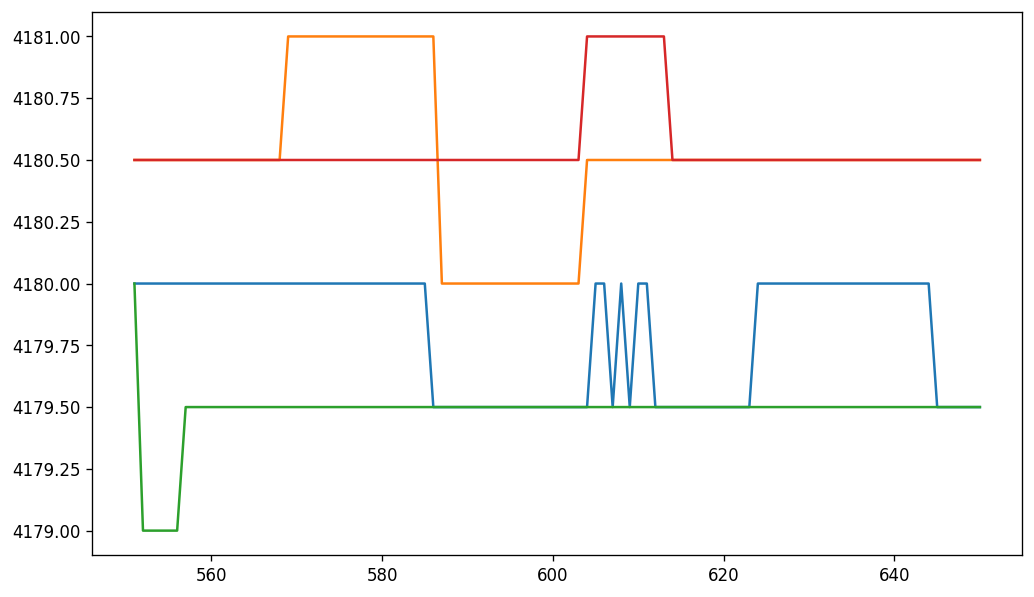

In [25]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots( dpi=120, figsize=(10,6))

plt.plot(L.loc[514+37:525+125][['bid_WDO', 'ask_WDO', 'bid_DOL', 'ask_DOL']])#.plot()#

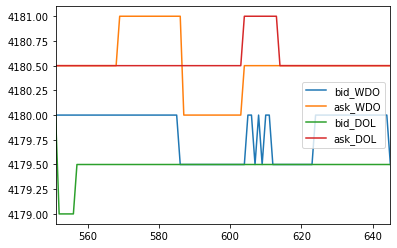

In [26]:
L.loc[514+37:525+120][['bid_WDO', 'ask_WDO', 'bid_DOL', 'ask_DOL']].plot()#

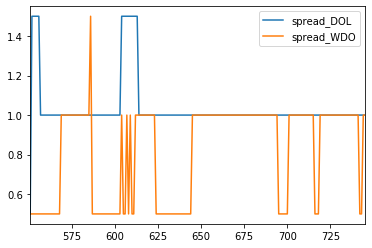

In [27]:
(L.loc[514+37:525+220][['spread_DOL', 'spread_WDO']]).plot()#

In [28]:
L.loc[525+170:][['bid_WDO', 'ask_WDO', 'bid_DOL', 'ask_DOL', 'spread_WDO', 'spread_DOL']]

,bid_WDO,ask_WDO,bid_DOL,ask_DOL,spread_WDO,spread_DOL
695,4180.0,4180.5,4179.5,4180.5,0.5,1.0
696,4180.0,4180.5,4179.5,4180.5,0.5,1.0
697,4180.0,4180.5,4179.5,4180.5,0.5,1.0
698,4180.0,4180.5,4179.5,4180.5,0.5,1.0
699,4180.0,4180.5,4179.5,4180.5,0.5,1.0
...,...,...,...,...,...,...
1797994,4187.0,4187.5,4187.0,4187.5,0.5,0.5
1797995,4187.0,4187.5,4187.0,4187.5,0.5,0.5
1797996,4187.0,4187.5,4187.0,4187.5,0.5,0.5
1797997,4187.0,4187.5,4187.0,4187.5,0.5,0.5


In [37]:
np.where(L.loc[515:]['ask_DOL'] == 4191)[0]

array([1726153, 1726154, 1726155, ..., 1745030, 1745031, 1745032])

In [41]:
L.loc[1745030+515:1745030+535]

,bid_WDO,q_bid_WDO,ask_WDO,q_ask_WDO,bid_DOL,q_bid_DOL,ask_DOL,q_ask_DOL,spread_WDO,spread_DOL
1745545,4190.0,454.0,4190.5,9.0,4190.0,135.0,4191.0,105.0,0.5,1.0
1745546,4190.0,454.0,4190.5,10.0,4190.0,135.0,4191.0,105.0,0.5,1.0
1745547,4190.0,454.0,4190.5,10.0,4190.0,135.0,4191.0,105.0,0.5,1.0
1745548,4190.0,454.0,4190.5,10.0,4190.0,135.0,4190.5,5.0,0.5,0.5
1745549,4190.0,454.0,4190.5,30.0,4190.0,135.0,4190.5,5.0,0.5,0.5
1745550,4190.0,454.0,4190.5,30.0,4190.0,135.0,4190.5,5.0,0.5,0.5
1745551,4190.0,454.0,4190.5,30.0,4190.0,140.0,4190.5,5.0,0.5,0.5
1745552,4190.0,454.0,4190.5,30.0,4190.0,140.0,4190.5,5.0,0.5,0.5
1745553,4190.0,454.0,4190.5,26.0,4190.0,140.0,4190.5,5.0,0.5,0.5
1745554,4190.0,454.0,4190.5,26.0,4190.0,140.0,4190.5,5.0,0.5,0.5


In [43]:
L['gap'] = L['ask_DOL'] - L['ask_DOL'].shift(1)

/home/asimovws/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
L.gap.unique()

array([ nan,  0. , -0.5,  1. ,  0.5, -1. ,  1.5, -1.5,  2. , -2. ,  2.5])

In [12]:
L['spread_WDO'] = L['1'] - L['0']

In [13]:
L['spread_DOL'] = L['3'] - L['2']

In [14]:
L [(L['spread_WDO'] == .5) & (L['spread_DOL'] == .5) & (L['0'] == L['2']) & (L['1'] == L['3'])]

,0,1,2,3,4,5,6,7,spread_WDO,spread_DOL
515,4179.0,4179.5,4179.0,4179.5,71.0,20.0,5.0,15.0,0.5,0.5
516,4179.0,4179.5,4179.0,4179.5,71.0,20.0,5.0,15.0,0.5,0.5
517,4179.0,4179.5,4179.0,4179.5,64.0,20.0,5.0,15.0,0.5,0.5
518,4179.0,4179.5,4179.0,4179.5,64.0,20.0,5.0,15.0,0.5,0.5
519,4179.0,4179.5,4179.0,4179.5,64.0,20.0,5.0,15.0,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...
1797994,4187.0,4187.5,4187.0,4187.5,213.0,239.0,50.0,55.0,0.5,0.5
1797995,4187.0,4187.5,4187.0,4187.5,213.0,239.0,50.0,55.0,0.5,0.5
1797996,4187.0,4187.5,4187.0,4187.5,213.0,239.0,50.0,55.0,0.5,0.5
1797997,4187.0,4187.5,4187.0,4187.5,213.0,239.0,50.0,55.0,0.5,0.5


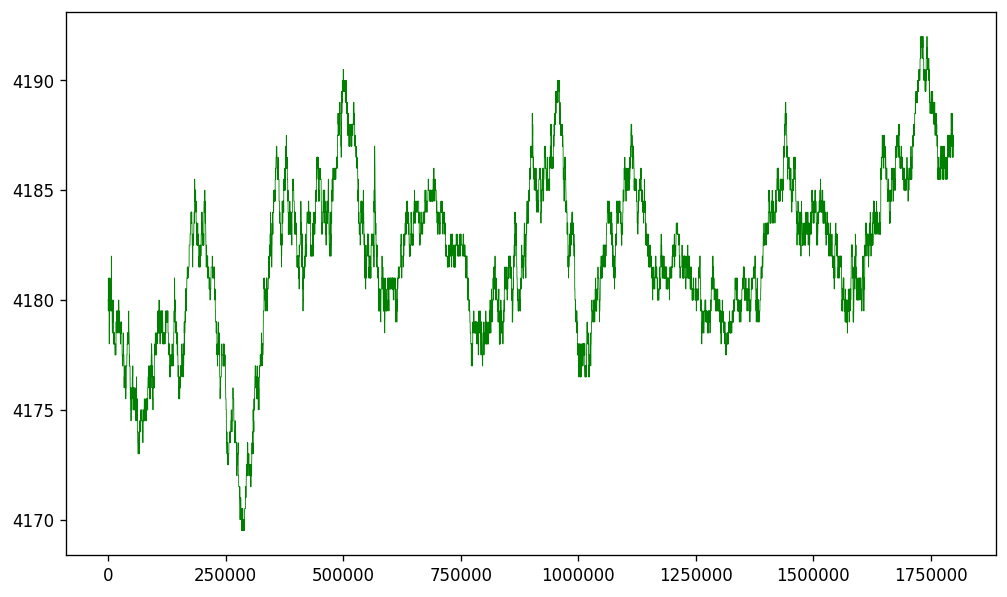

In [36]:
import matplotlib.pyplot as plt

#L[['bid_WDO', 'q_bid_WDO', 'ask_WDO', 'q_ask_WDO', 'bid_DOL', 'q_bid_DOL', 'ask_DOL', 'q_ask_DOL', 'spread_WDO', 'spread_DOL']]
fig, axes = plt.subplots( dpi=120, figsize=(10,6))
data = L[['bid_WDO']]#[(L['spread_WDO'] > .5) & (L['spread_DOL'] > .5)]
data2 = L[['ask_DOL']]#[(L['spread_WDO'] > .5) & (L['spread_DOL'] > .5)]
# data3 =  L[[4]]#[(L['spread_WDO'] > .5) & (L['spread_DOL'] > .5)]
# data4 =  L[[6]]#[(L['spread_WDO'] > .5) & (L['spread_DOL'] > .5)]

# plt.plot(data, color='red', linewidth=1)
plt.plot(data2, color='green', linewidth=0.5)

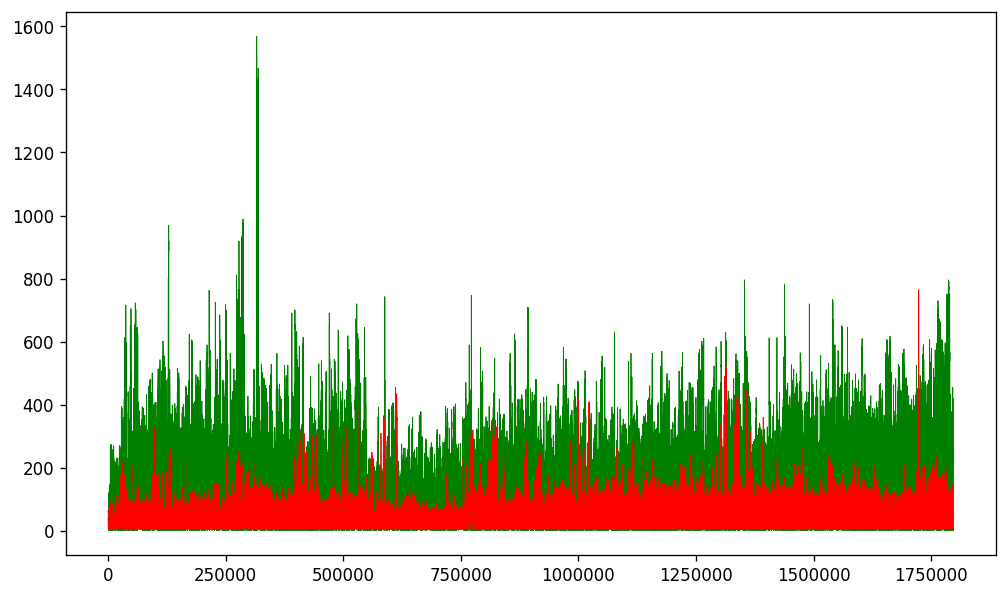

In [22]:
fig, axes = plt.subplots(dpi=120, figsize=(10,6))

plt.plot(data3, color='green', linewidth=0.5)
plt.plot(data4, color='red', linewidth=0.5)

In [16]:
np.where(L['spread_WDO'] != 0.5)[0][0]

75

In [66]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

# grangers_causation_matrix(df, variables = df.columns)     

In [ ]:
grangers_causation_matrix(L, variables = L.columns)

/home/asimovws/.local/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  'rank is %d' % (J, J_), ValueWarning)
/home/asimovws/.local/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 5
  'rank is %d' % (J, J_), ValueWarning)
/home/asimovws/.local/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  'rank is %d' % (J, J_), ValueWarning)
/home/asimovws/.local/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 7
  'rank is %d' % (J, J_), ValueWarning)
/home/asimovws/.local/lib/python3.6/site-packages/statsmodels/base/m

In [23]:
B.to_csv('13-11-2019.csv', sep = ',', header = True, index = False)

,bid_WDO,q_bid_WDO,ask_WDO,q_ask_WDO,bid_DOL,q_bid_DOL,ask_DOL,q_ask_DOL,spread_WDO,spread_DOL
0,4180.0,40.0,4180.5,23.0,4179.0,60.0,4180.0,60.0,0.5,1.0
1,4180.0,40.0,4180.5,23.0,4179.0,60.0,4180.0,60.0,0.5,1.0
2,4180.0,33.0,4180.5,23.0,4179.0,60.0,4180.0,60.0,0.5,1.0
3,4180.0,33.0,4180.5,23.0,4179.0,60.0,4180.0,60.0,0.5,1.0
4,4180.0,33.0,4180.5,23.0,4179.0,60.0,4180.0,60.0,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...
1797994,4187.0,213.0,4187.5,239.0,4187.0,50.0,4187.5,55.0,0.5,0.5
1797995,4187.0,213.0,4187.5,239.0,4187.0,50.0,4187.5,55.0,0.5,0.5
1797996,4187.0,213.0,4187.5,239.0,4187.0,50.0,4187.5,55.0,0.5,0.5
1797997,4187.0,213.0,4187.5,239.0,4187.0,50.0,4187.5,55.0,0.5,0.5
